<a href="https://colab.research.google.com/github/marioTavFer/somePython/blob/main/coint_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos Multivariados aplicados a séries temporais (Cointegração)

# Carregamento de bibliotecas

Os pacotes que usaremos nessa seção estão listados abaixo.

In [ ]:
import pandas as pd  # Importa o pacote "pandas" para análise e manipulação de dados
import numpy as np  # Importa o pacote "numpy" para computação numérica eficiente
import statsmodels.api as sm  # Importa o pacote "statsmodels" para análise estatística
from statsmodels.tsa.stattools import adfuller  # Importa a função "adfuller" do módulo "stattools" do pacote "statsmodels.tsa" para teste de estacionaridade
from statsmodels.tsa.vector_ar import vecm # Função para estimar vecm
from plotnine import *  # Importa o pacote "plotnine" para visualização de dados com a gramática de gráficos do R
from matplotlib import pyplot as plt

# Modelos multivariados não estacionários

## Existe cointegração entre a PETR4 e PETR3?

Para ilustrar a metodologia de Engle-Granger, vamos ver se podemos encontrar uma relação de cointegração entre as ações da PETR4 e PETR3 no período de 28 de março de 2021 até 28 de março de 2022. A ideia básica é a de que os preços de ambas as ações seguem uma mesma tendência estocástica, visto que possuem uma trajetória comum.

In [ ]:
# Importa os dados das séries
petro = pd.read_csv("https://aluno.analisemacro.com.br/download/51000/?tmstv=1687959193", parse_dates = ['date'])

Visualizamos as séries e verificamos claramente que não são estacionárias, o que permite aplicarmos o Teste de Engle-Granger (fica ao leitor a aplicação de algum tipo de teste de estacionariedade).

Há claramente uma trajetória comum entre as séries.

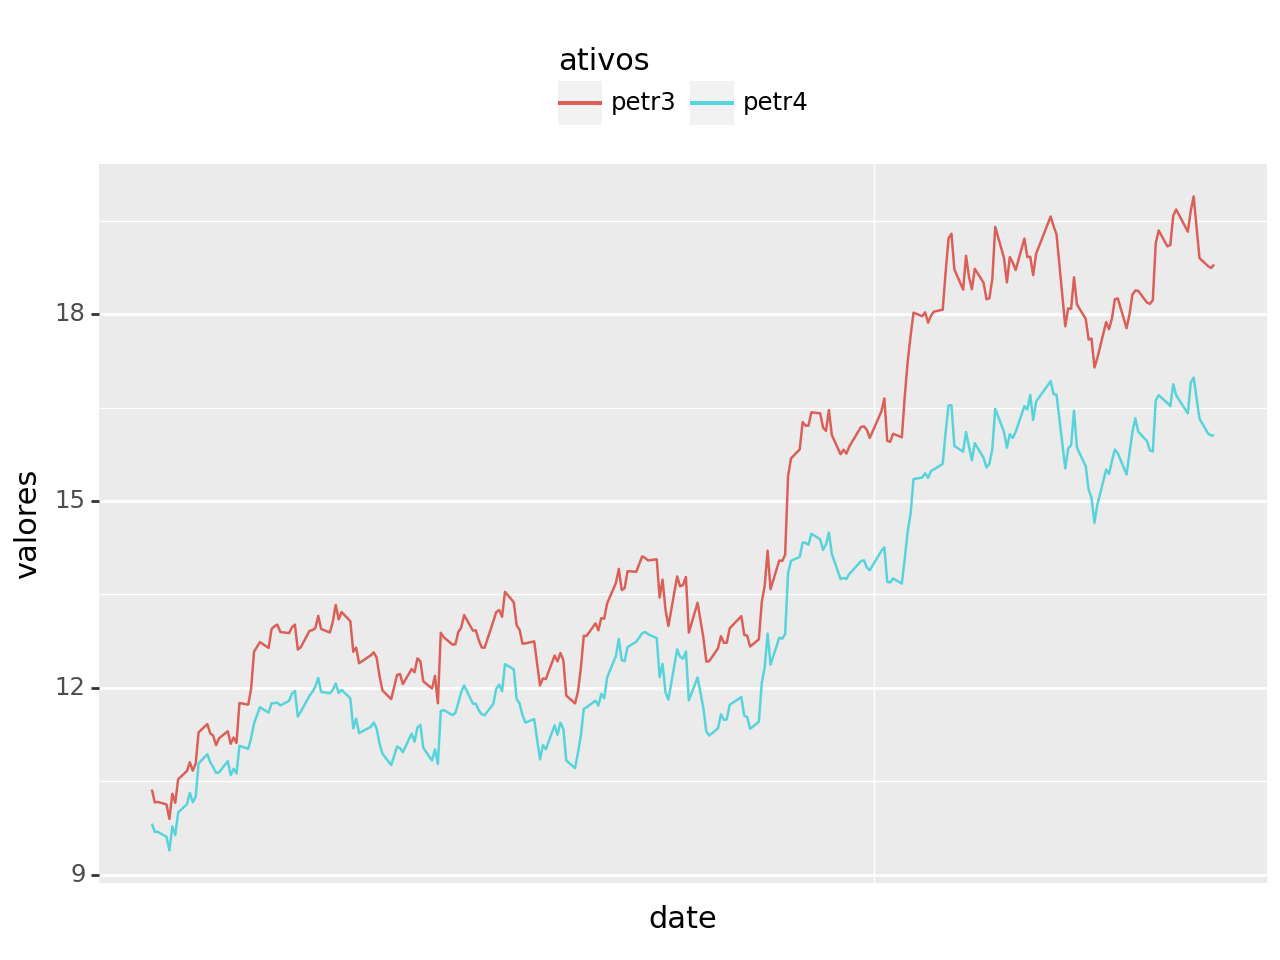

<Figure Size: (640 x 480)>

In [ ]:
# Visualização do gráfico de série temporal
# Converter os dados para o formato "long"
petro_long = petro.melt(id_vars = "date",
                                  var_name = "ativos",
                                  value_name = "valores")

# Criar o gráfico
(ggplot(petro_long)
 + geom_line(aes(x = "date", y="valores", color="ativos"))
 + scale_x_date(date_labels = "%Y", date_breaks = "4 year")
 + theme(legend_position = "top")
)

Antes, podemos dar uma olhada na correlação entre as variáveis abaixo.

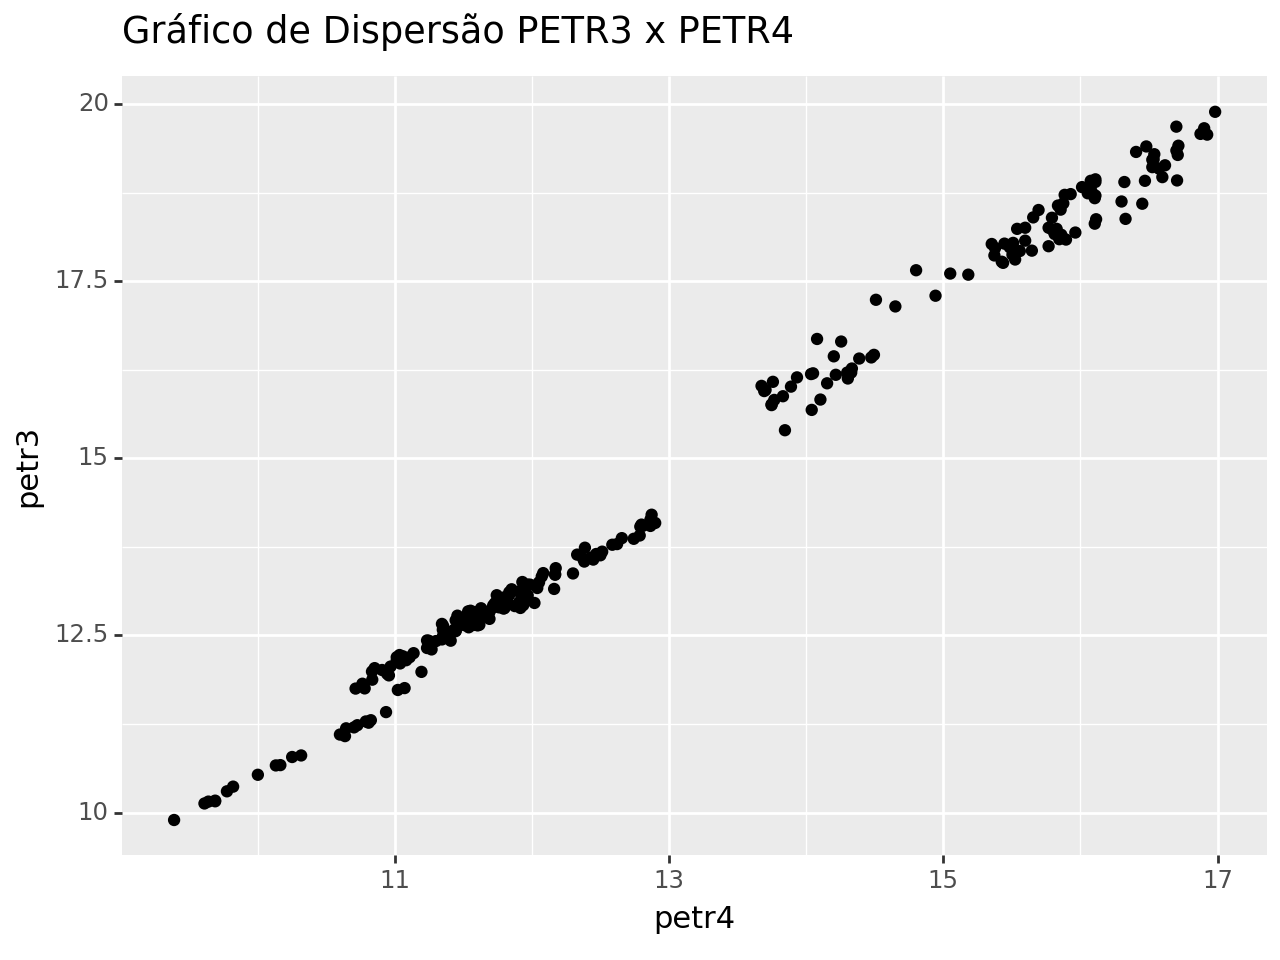

<Figure Size: (640 x 480)>

In [ ]:
# Visualização do gráfico de dispersão
# Criar o gráfico
(ggplot(petro)
 + geom_point(aes(x = "petr4", y = "petr3"))
 + labs(title = "Gráfico de Dispersão PETR3 x PETR4")
)

Podemos perceber a relação entre os preços das duas ações. Agora partimos para a estimação da regressão linear, em que `petr3 ~ petr4`.

In [ ]:
# coloca a data no índice
petro.set_index("date", inplace = True)
# Realizando a regressão
petr4 = sm.add_constant(petro["petr4"])  # Adicionando uma coluna de constantes aos dados de "petr4"
petr3 = petro[["petr3"]]

 # Criação do modelo de regressão linear com "petr3" como variável dependente e "petr4" como variável independente
reg_petro = sm.OLS(petr3, petr4).fit()

print(reg_petro.summary())

                            OLS Regression Results                            
Dep. Variable:                  petr3   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.874e+04
Date:                Wed, 27 Sep 2023   Prob (F-statistic):          1.70e-273
Time:                        18:27:01   Log-Likelihood:                 20.924
No. Observations:                 249   AIC:                            -37.85
Df Residuals:                     247   BIC:                            -30.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6896      0.089    -30.098      0.0

Uma vez estimada a regressão, vamos checar se os nossos resíduos são estacionários.

In [ ]:
# Verificando a estacionariedade dos resíduos
residuos_petro = reg_petro.resid
adf_resid_petro = adfuller(residuos_petro)

print("Estatística ADF:", adf_resid_petro[0])
print("Valor-p:", adf_resid_petro[1])
print("Valores críticos:", adf_resid_petro[4])

Estatística ADF: -4.194109443349788
Valor-p: 0.0006741926650856655
Valores críticos: {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}


Ao comparar as estatísticas de teste com os valores da tabela, é possível rejeitar a hipótese nula de presença de raiz unitária. Isto é, nossos resíduos são estacionários e podemos, então, passar ao passo 2 do método de Engle-Granger.

Aqui, vamos estimar o seguinte modelo de correção de erros

\begin{equation} \Delta petr3_t = \psi_0 + \psi_1 \hat{u_{t-1}} + \psi_3 \Delta petr4_{t} + \varepsilon_t \end{equation}

onde $\hat{u_{t-1}}$ serão os resíduos da regressão que acabamos de estimar.

O código abaixo, por fim, estima o modelo de correção de erros.

In [ ]:
# Cria coluna de resíduos
petro['residuos_petro'] = residuos_petro

# Ajuste do modelo de ECM
ecm = sm.OLS.from_formula("petr3.diff() ~ 1 + residuos_petro.shift() + petr4.diff()", data = petro).fit()

# Verifica as principais estatísticas
print(ecm.summary())

                            OLS Regression Results                            
Dep. Variable:           petr3.diff()   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     1399.
Date:                Wed, 27 Sep 2023   Prob (F-statistic):          9.47e-135
Time:                        18:27:01   Log-Likelihood:                 236.27
No. Observations:                 248   AIC:                            -466.5
Df Residuals:                     245   BIC:                            -456.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

Observe que o coeficiente que dá a velocidade do ajustamento é `residuos_petro.shift()`, isto é, negativo, no valor de `-0.0985` conforme vimos acima.

Ademais, mudanças na `petr4.diff()` têm impacto positivo sobre as mudanças da `petr3.diff()`, com o coeficiente de `1.1090` sendo estatisticamente significativo.

# Estimando um VECM no Python

De modo a ilustrar a aplicação do VECM, vamos construir um modelo com foco na trajetória da Dívida Bruta. Para isso, devemos importar as variáveis relevantes conforme o código abaixo.

In [ ]:
dados_vecm = pd.read_csv("https://aluno.analisemacro.com.br/download/51036/?tmstv=1687978789", parse_dates=['data'])

Visualizamos os dados com o código abaixo.

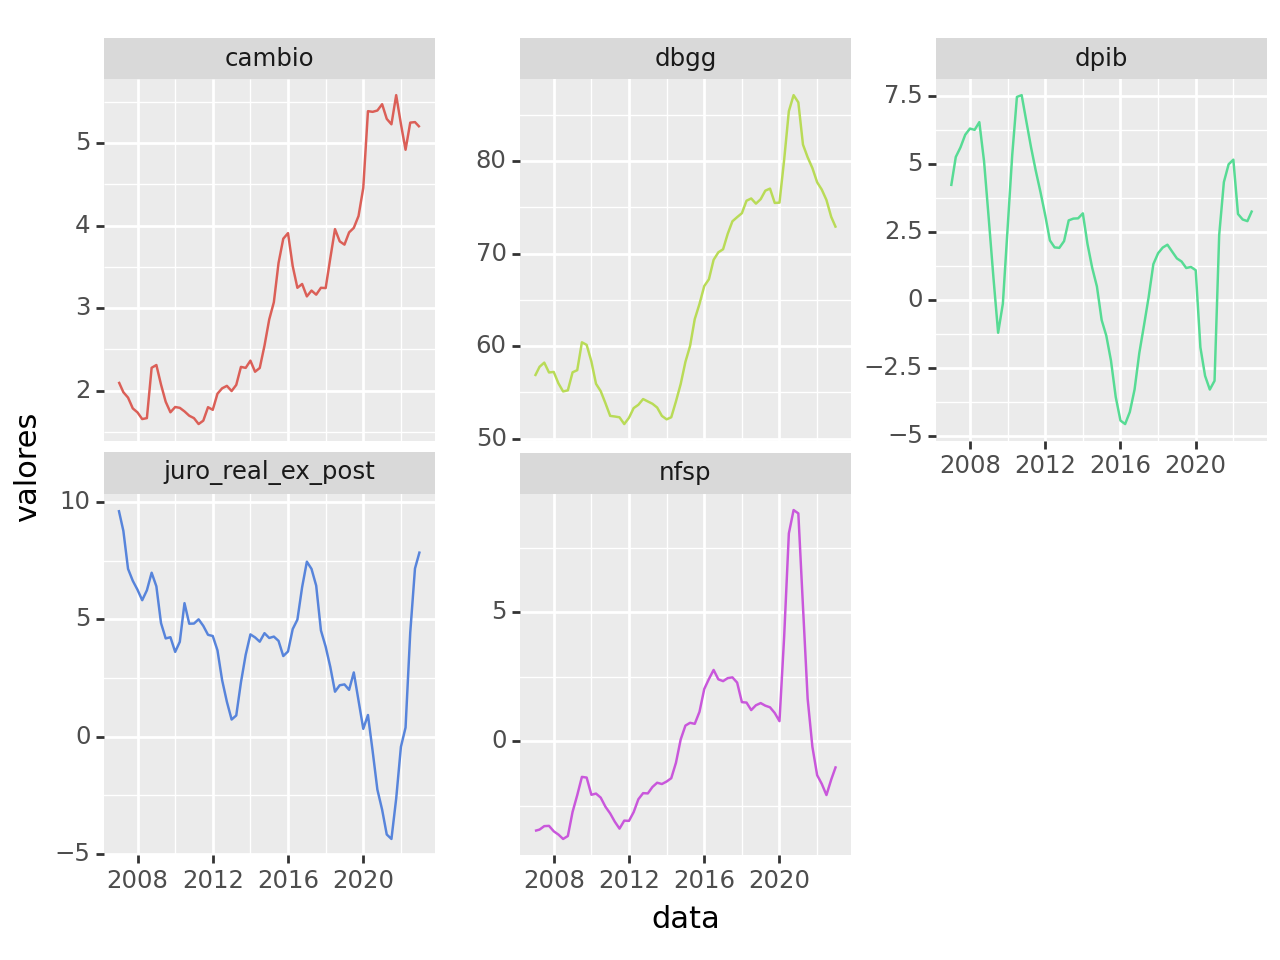

<Figure Size: (640 x 480)>

In [ ]:
# Converter os dados para o formato "long"
dados_vecm_long = dados_vecm.melt(id_vars = "data",
                                  var_name = "variaveis",
                                  value_name = "valores")

# Criar o gráfico
(ggplot(dados_vecm_long)
 + geom_line(aes(x="data", y="valores", color="variaveis"))
 + facet_wrap("variaveis", scales="free_y")
 + scale_x_date(date_labels = "%Y", date_breaks = "4 year")
 + theme(legend_position = "none")
)

Uma vez importadas as séries, precisamos verificar se há cointegração entre elas.

Utilizamos o teste de Johansen, por meio da função `select_coint_rank`. Em seus parâmetros, definimos as variáveis, o termo determinístico (-1 sem termo; 0 para constante; 1 para linear), o número de diferenças defasadas e o método a ser utilizado pelo teste, `trace` e `maxeig`.

O Teste vai determinar o número de vetores de cointegração ou relações de cointegração (r). O modelo VECM é utilizado quando os vetores de cointegração são maiores que 0 e menores que o número de variáveis no modelo (K).

0 < r < K; aplicar VECM

No nosso exemplo (onde K = 5), a aplicação do VECM é apropriada se o r seja o valor de 2,3 e 4, pois isso satisfaz a condição acima 0 < r < K (ou seja, 0 < r < 5).

O teste pode ser realizado usando tanto a estatística de Traço (Trace statistic) quanto a estatística do Autovalor Máximo (Maximum Eigenvalue statistic) para testar as seguintes hipóteses:

Hipótese Nula (H0): Não existe cointegração entre as variáveis (r = 0).
Hipótese Alternativa (H1): Existe pelo menos uma relação de cointegração entre as variáveis (r > 0).

O teste de cointegração de Johansen avalia se a estatística de teste excede o valor crítico para rejeitar a hipótese nula e inferir a presença de cointegração entre as variáveis.

In [ ]:
dados_vecm.set_index("data", inplace = True)

johansen_trace = vecm.select_coint_rank(dados_vecm, det_order = 0, k_ar_diff = 1, method = "trace")
johansen_maxeig = vecm.select_coint_rank(dados_vecm, det_order = 0, k_ar_diff = 1, method = "maxeig")


print(johansen_trace)
print(johansen_maxeig)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   5          92.10          69.82
  1   5          51.34          47.85
  2   5          22.52          29.80
-------------------------------------
Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          40.76          33.88
  1   2          28.82          27.59
  2   3          11.77          21.13
-------------------------------------


Cada linha da tabela resultante mostra um teste com:

  - Hipótese nula: "O rank de cointegração é r_0"
  - Hipótese alternativa:"O rank de cointegração é maior que r_0 e $\leq$ r_1".

A última linha contém informações sobre o rank de cointegração a ser escolhido. Se a estatística de teste dessa linha for menor que o valor crítico correspondente, utiliza-se r_0 como o rank de cointegração. Caso contrário, utiliza-se r_1.

Essa informação é relevante para determinar o número de vetores de cointegração adequados para o modelo. Se o teste estatístico para r_0 for estatisticamente significativo, indica que o número de vetores de cointegração é pelo menos r_0. Por outro lado, se o teste para r_1 for significativo, indica que o número de vetores de cointegração é maior que r_0 e r_1.

A partir das tabelas acima, chegamos a conclusão que r_0 = 2. Isso pode ser obtido usando a propriedade `rank`.

In [ ]:
johansen_trace.rank
johansen_maxeig.rank

johansen_maxeig.rank

2

Determinado a ordem de cointegração, determinado a ordem de defasagem. Fazemos isso por meio da função `select_order`. Como parâmetros, temos os dados, o máximo de defasagens e o termo determínistico.

Entre as escolhas do último, temos:

 - "N" - sem termos determinísticos
 - "co" - constante fora da relação de cointegração
 - "ci" - constante dentro da relação de cointegração
 - "lo" - tendência linear fora da relação de cointegração
 - "li" - tendência linear dentro da relação de cointegração

In [ ]:
lag_order = vecm.select_order(data = dados_vecm, maxlags = 5, deterministic = "ci")
lag_order.selected_orders

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was pro

{'aic': 5, 'bic': 1, 'hqic': 4, 'fpe': 4}

É sugerido a escolha de diferentes defasagens de acordo com diferentes critérios. Escolhemos o `bic = 1`

Para ajustar um modelo VECM aos dados, primeiro criamos um objeto VECM no qual definimos:

 - Os termos determinísticos
 - A ordem de defasagem (lag order)
 - O rank de cointegração


In [ ]:
vecm_modelo = vecm.VECM(dados_vecm,
                       deterministic="ci",
                       k_ar_diff = lag_order.bic,  # = 1
                       coint_rank = johansen_maxeig.rank)  # = 2

vecm_res = vecm_modelo.fit()

print(vecm_res.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.


  Det. terms outside the coint. relation & lagged endog. parameters for equation dbgg   
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
L1.dbgg                  0.4057      0.199      2.041      0.041       0.016       0.795
L1.juro_real_ex_post    -0.0785      0.158     -0.498      0.619      -0.387       0.230
L1.nfsp                 -0.0113      0.256     -0.044      0.965      -0.513       0.491
L1.cambio                1.2477      0.780      1.599      0.110      -0.281       2.777
L1.dpib                 -0.2020      0.195     -1.035      0.301      -0.585       0.180
Det. terms outside the coint. relation & lagged endog. parameters for equation juro_real_ex_post
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
L1.dbgg      

A representação do valores em VAR podem ser obtidos por meio da propriedade `var_rep`.

In [ ]:
vecm_res.var_rep

array([[[ 1.41375584, -0.08536146, -0.02659502,  1.17626795,
         -0.23355838],
        [-0.09173148,  1.43521314, -0.44171427, -0.42627947,
         -0.24077763],
        [ 0.17429116, -0.01648485,  1.27862109,  1.16897731,
         -0.039309  ],
        [ 0.02317379, -0.04053679, -0.07447212,  1.28198379,
         -0.01242192],
        [-0.27608078,  0.03127956,  0.26103657, -0.77346052,
          1.27905325]],

       [[-0.40570265,  0.07845381,  0.0112659 , -1.24774092,
          0.20204921],
        [ 0.13182972, -0.4765953 ,  0.28178727,  0.20065519,
          0.13134929],
        [-0.12780611, -0.04116342, -0.57976932, -1.25019979,
         -0.02183696],
        [-0.02103035,  0.03814584,  0.06378313, -0.29071007,
          0.00778746],
        [ 0.32215148, -0.06318908, -0.25771294,  0.22276878,
         -0.5109834 ]]])

De forma a gerar as funções de impulso-resposta, podemos aplicar o método `irf`.

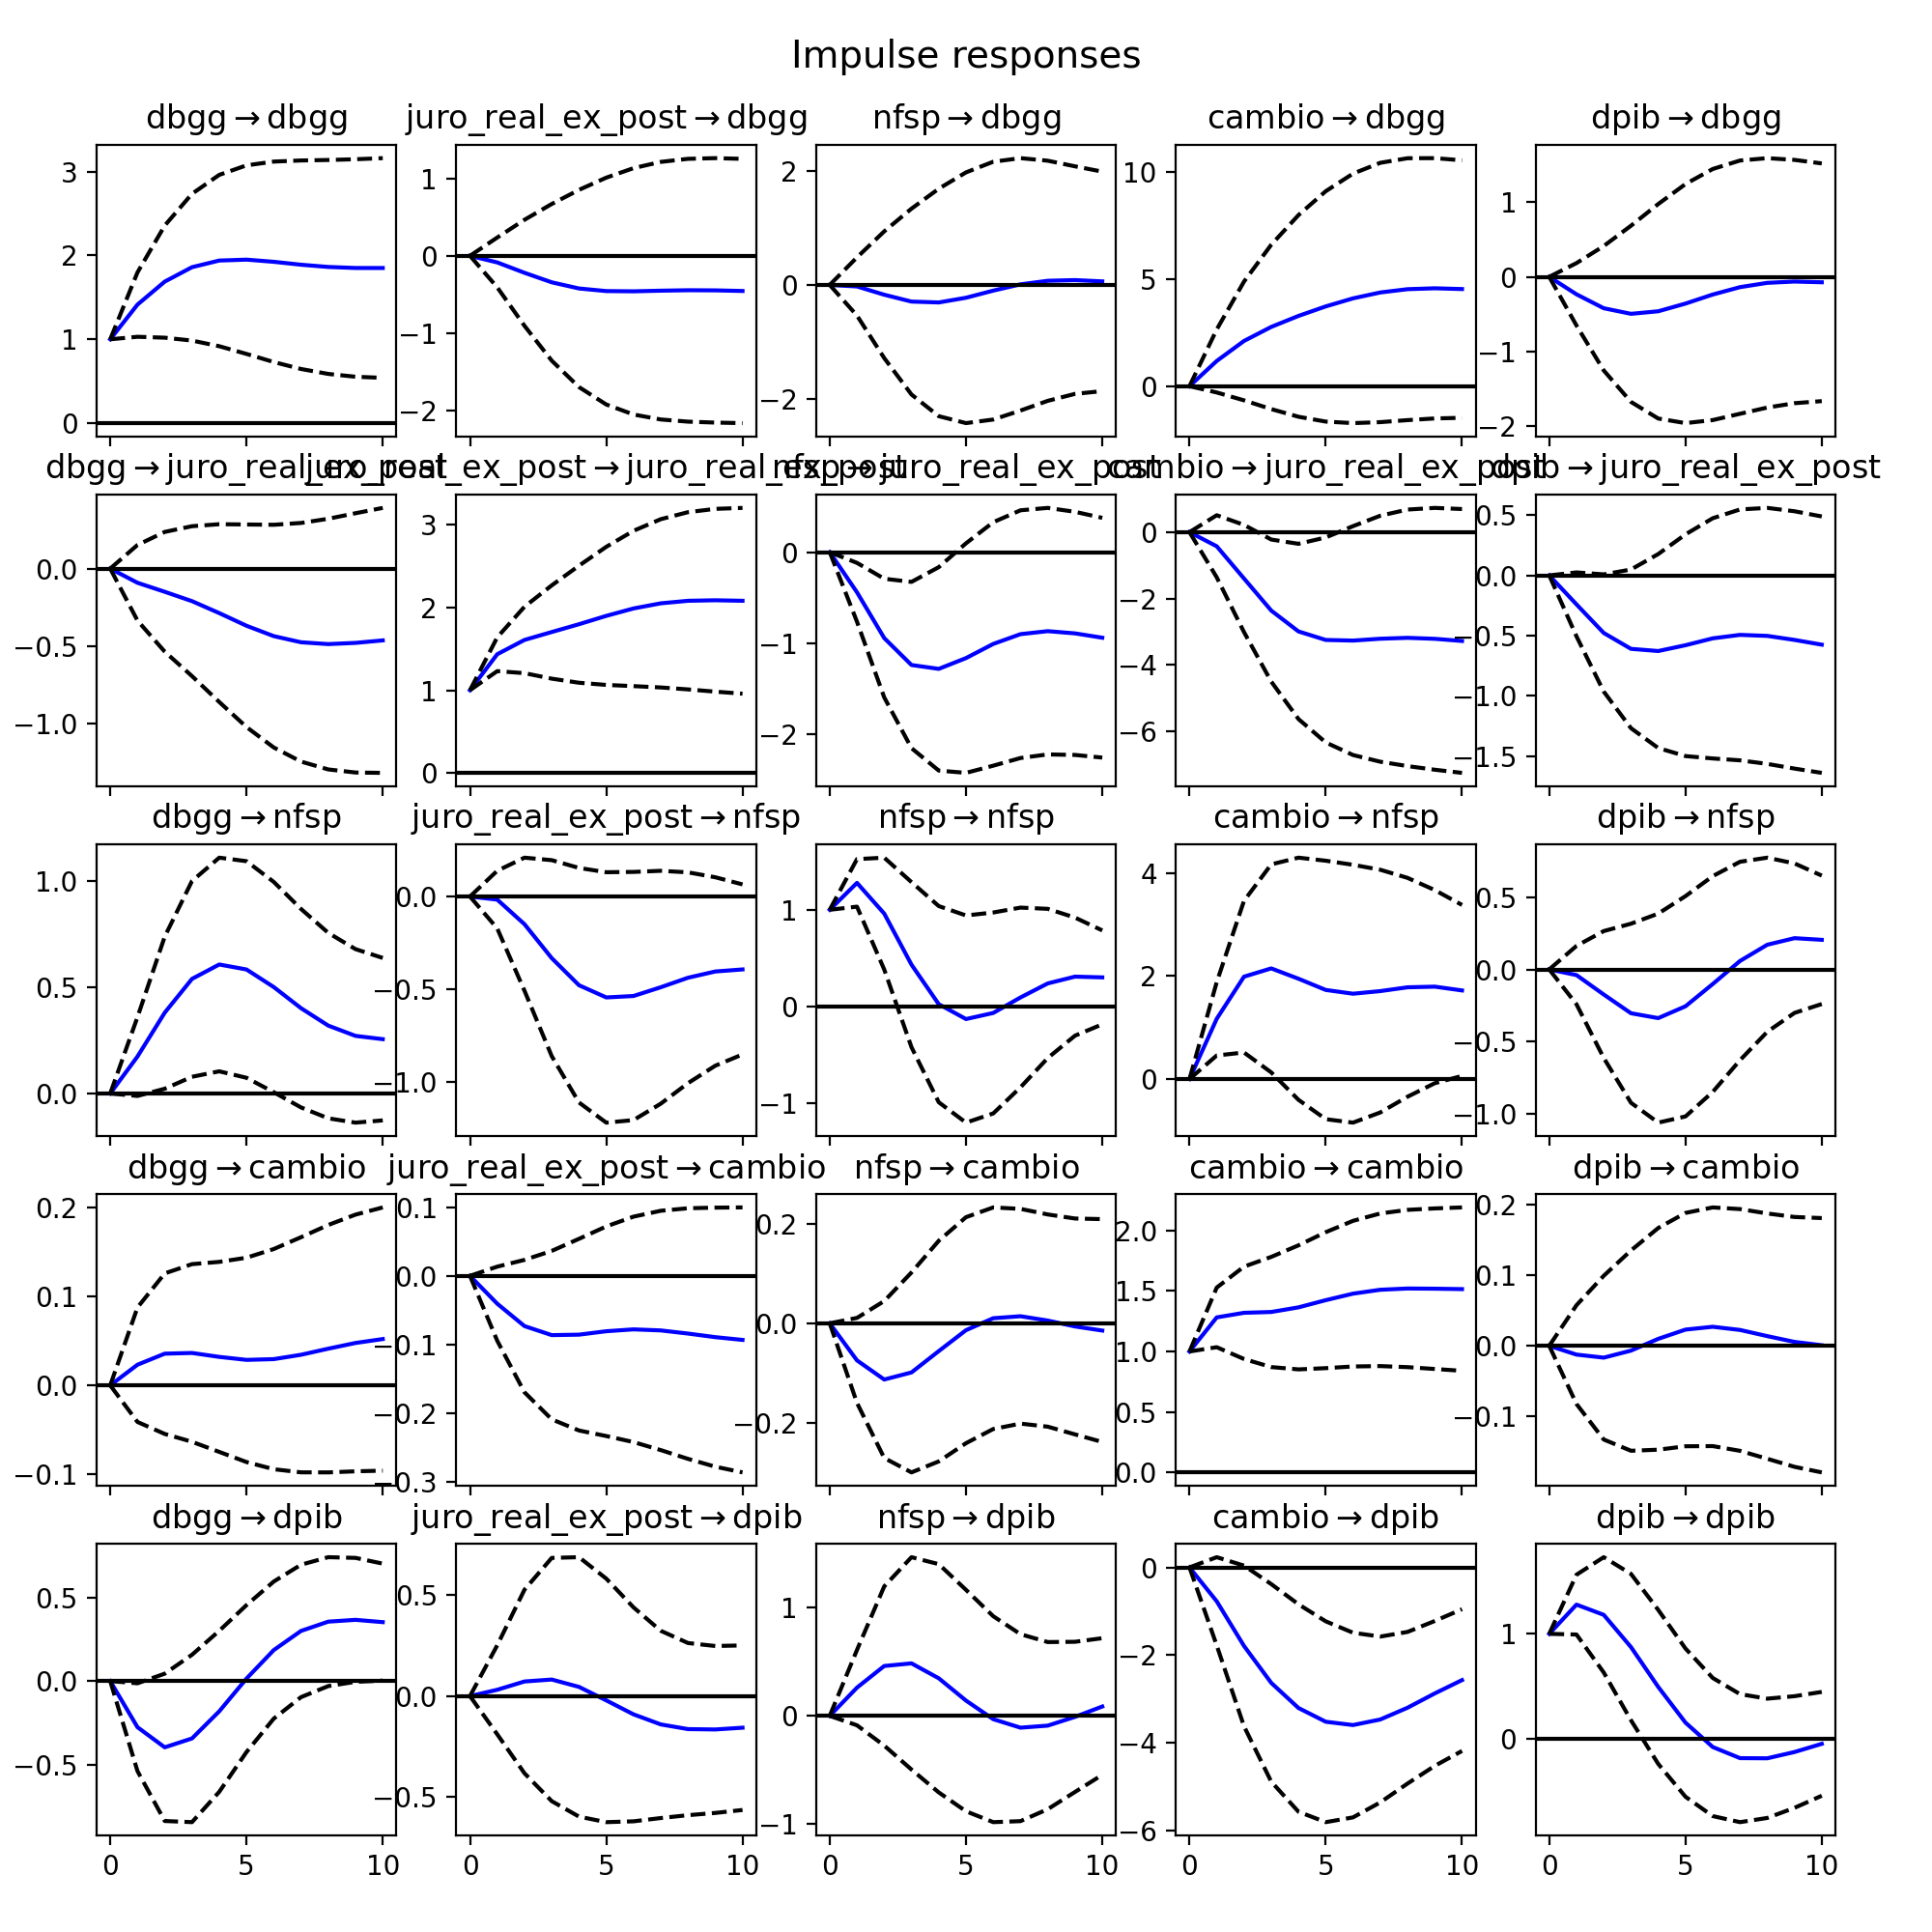

In [ ]:
irf_vecm = vecm_res.irf(periods = 10)
irf_vecm.plot();